# CNN with layers for image feaures and tabular data
### A multi-target regression approach is used

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random

import math

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-06-02 22:00:47.376272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 22:00:47.376430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 22:00:47.570726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data, append image paths, define target columns

In [2]:
train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')

sd_columns = [col for col in train.columns if col.endswith('_sd')]
train = train.drop(columns=sd_columns)

train_image_folder = '/kaggle/input/planttraits2024/train_images'
train['image_path'] = train['id'].apply(lambda x: os.path.join(train_image_folder, f"{x}.jpeg"))

test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test_image_folder = '/kaggle/input/planttraits2024/test_images'
test['image_path'] = test['id'].apply(lambda x: os.path.join(test_image_folder, f"{x}.jpeg"))

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

# Image processing and dataset functions

In [3]:
# Define image augmentation operations
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_crop(img, size=[224, 224, 3])  # Random cropping
    return img

# Process image with augmentation
def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = augment_image(img)  # Apply augmentation
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular_data, targets):
    img = process_image(file_path)
    return (img, tabular_data), targets

# Plot train data

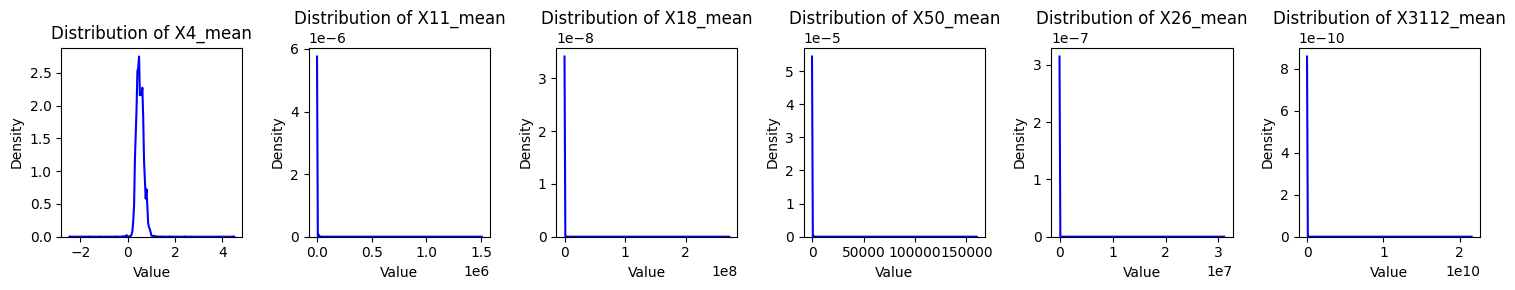

In [4]:
def plot_data(df):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(mean_columns) // n_cols + (len(mean_columns) % n_cols > 0)

    for i, col in enumerate(mean_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    
plot_data(train)

# Drop bad training data

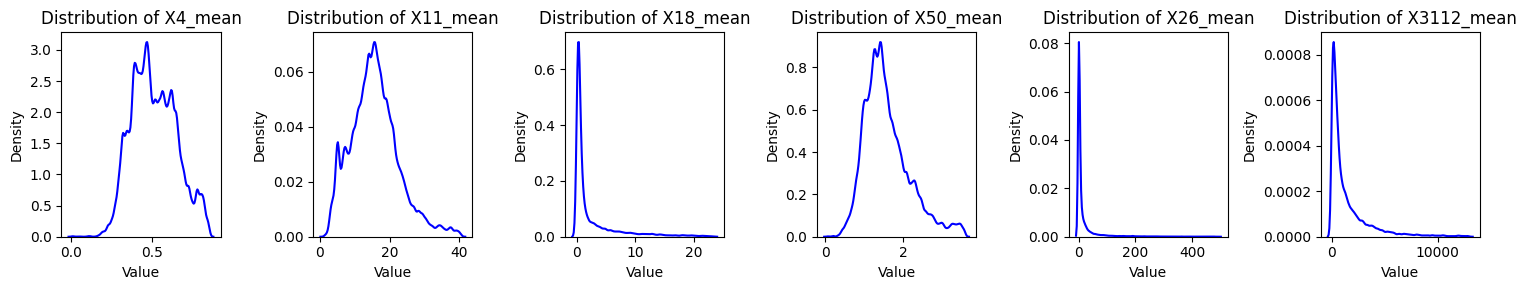

In [5]:
for column in mean_columns:
    upper_quantile = train[column].quantile(0.98)  
    train = train[(train[column] < upper_quantile)]
    train = train[(train[column] > 0)]    
plot_data(train)

# Normalize target values

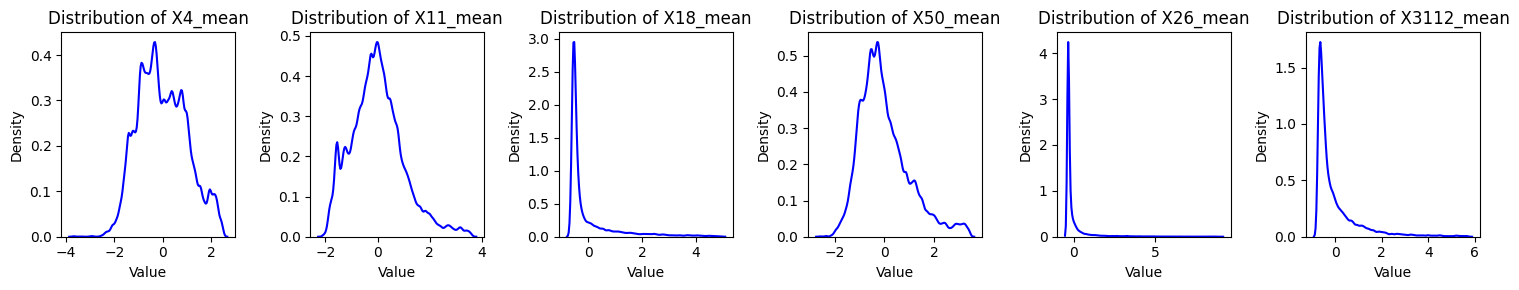

In [6]:
original_means = {}
original_stds = {}

for column in mean_columns:
    # Calculate the mean and standard deviation for each column
    original_means[column] = train[column].mean()
    original_stds[column] = train[column].std()
    
    # Apply the scaling: (value - mean) / std
    # This standardizes each column to have a mean of 0 and std of 1
    train[column] = (train[column] - original_means[column]) / original_stds[column]
    
plot_data(train)

# Normalize tabular inputs
### This is crucial with a CNN (in contrast to with XGBoost - where it doesn't really matter...)
### We should probably look at this in more detail - but there is so much data!!!

In [7]:
x = train.drop(columns=['id', 'image_path'] + mean_columns)

for column in x.columns:
    min_val = x[column].min()
    max_val = x[column].max()
    x[column] = (x[column] - min_val) / (max_val - min_val)

# Create train and validation sets

In [8]:
y = train[mean_columns]
x_paths = train['image_path']

train_tabular, val_tabular, train_targets, val_targets = train_test_split(
    x, y, test_size=0.2, random_state=42)

train_paths, val_paths = train_test_split(
    x_paths, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_tabular.to_numpy(), train_targets.to_numpy()))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_tabular.to_numpy(), val_targets.to_numpy()))

# Apply the processing function
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Define model: CNN with layers for tabular and image feaures / multi-target regression

In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the image model pathway
image_input = Input(shape=(224, 224, 3))

# Custom CNN architecture
image_feature_layers = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
image_feature_layers = MaxPooling2D((2, 2))(image_feature_layers)
image_feature_layers = Conv2D(64, (3, 3), activation='relu', padding='same')(image_feature_layers)
image_feature_layers = MaxPooling2D((2, 2))(image_feature_layers)
image_feature_layers = Conv2D(128, (3, 3), activation='relu', padding='same')(image_feature_layers)
image_feature_layers = MaxPooling2D((2, 2))(image_feature_layers)
image_feature_layers = Flatten()(image_feature_layers)
image_feature_layers = Dense(256, activation='relu')(image_feature_layers)
image_feature_layers = Dropout(0.3)(image_feature_layers)  # Add dropout for regularization

tabular_input_shape = x.shape[1]
target_columns_shape = y.shape[1]

# Define the tabular model pathway
tabular_input = Input(shape=(tabular_input_shape,))
tabular_dense = Dense(512, activation='relu')(tabular_input)
tabular_dense = Dropout(0.3)(tabular_dense)  # Add dropout for regularization

# Concatenate both pathways
concat = Concatenate()([image_feature_layers, tabular_dense])
concat_dense = Dense(256, activation='relu')(concat)
concat_dense = Dropout(0.3)(concat_dense)  # Continue to use dropout for regularization

# Output layer for 6 targets (assuming 'mean_columns' is your output size)
output = Dense(target_columns_shape, activation='linear')(concat_dense)  # Use linear activation for regression

# Create the model
model = Model(inputs=[image_input, tabular_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Display the model summary to check the architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 163)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 25,690,368 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     83,968 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │      1,542 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,065,990 (99.43 MB)

 Trainable params: 26,065,990 (99.43 MB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3014s 2s/step - loss: 88.0800 - mae: 2.3395 - val_loss: 0.8885 - val_mae: 0.6484


# Save weights

In [11]:
model.save("model.keras")

# Normalize test data for predictions
### Same simple normaliziation we do on train

In [12]:
# Prepare tabular data (excluding 'id' and 'image_path')
test_tabular = test.drop(columns=['id', 'image_path'])

#normalize tabular data
for column in test_tabular.columns:
    min_val = test_tabular[column].min()
    max_val = test_tabular[column].max()
    test_tabular[column] = (test_tabular[column] - min_val) / (max_val - min_val)

# Predict

205/205 ━━━━━━━━━━━━━━━━━━━━ 154s 751ms/step


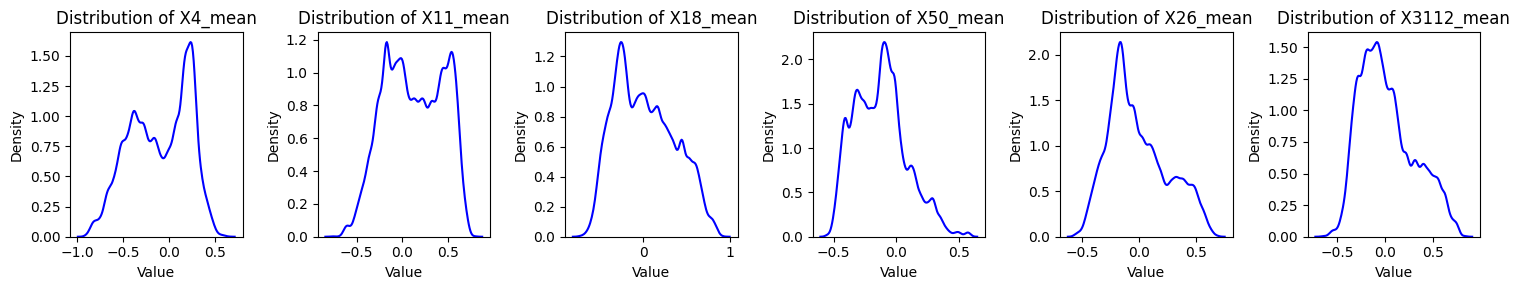

NaN values
 X4_mean       0
X11_mean      0
X18_mean      0
X50_mean      0
X26_mean      0
X3112_mean    0
dtype: int64


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,0.212906,-0.283515,0.166268,-0.108856,-0.115300,-0.237906
1,-0.392127,0.439177,-0.280288,-0.240294,-0.150147,-0.079299
2,-0.352680,0.320793,-0.292980,-0.145215,-0.222951,-0.226791
3,-0.423710,0.533510,-0.265150,-0.369544,-0.213859,-0.079599
4,0.032827,-0.136331,-0.040150,-0.119189,-0.262346,-0.415054
...,...,...,...,...,...,...
6540,0.257956,-0.224424,0.209407,0.012499,0.143350,0.108663
6541,0.121371,0.138562,0.768453,-0.174230,0.524530,0.708306
6542,-0.386608,0.585632,0.074677,-0.489480,-0.008850,0.277077
6543,-0.514994,0.530116,-0.378759,-0.302607,-0.223884,-0.160959


In [13]:
test_tabular_np = test_tabular.to_numpy()

# Create a TensorFlow dataset for the image paths and map them through the preprocessing function
test_images_ds = tf.data.Dataset.from_tensor_slices(test['image_path'])\
    .map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Create a TensorFlow dataset for the tabular data
test_tabular_ds = tf.data.Dataset.from_tensor_slices(test_tabular_np)

# Zip the two datasets together
test_ds = tf.data.Dataset.zip((test_images_ds, test_tabular_ds))

# Prepare the dataset for prediction by ensuring the structure matches the model's expectations
test_ds_for_prediction = test_ds.map(lambda image, tabular: ((image, tabular),), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the dataset
test_ds_batched = test_ds_for_prediction.batch(32)

# Use the model to predict on the batched dataset
predictions = model.predict(test_ds_batched)

predictions_df = pd.DataFrame(predictions, columns=mean_columns)
test = pd.concat([test.reset_index(drop=True), predictions_df], axis=1)

plot_data(test)

#Verify we didn't predict and NaNs..
print("NaN values\n", test[mean_columns].isna().sum())
test[mean_columns]

# Denormalize predictions / adjust to original scaling

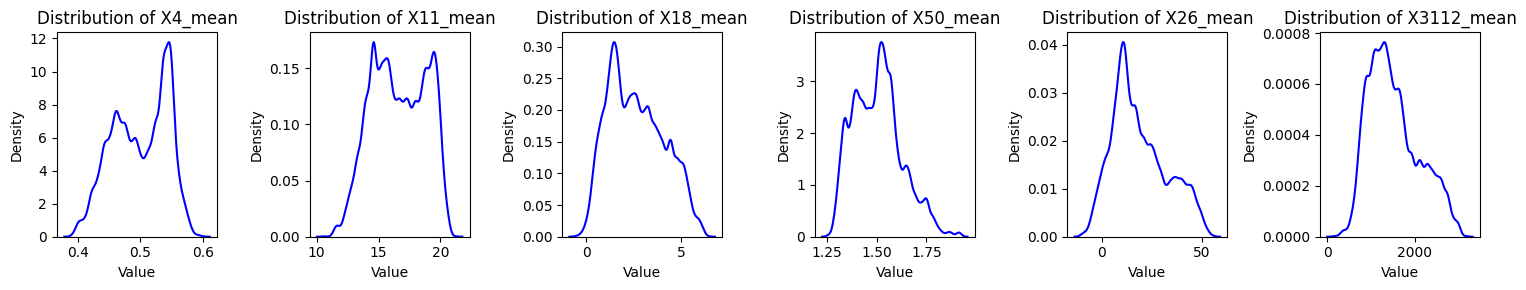

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,0.542441,13.826695,3.255090,1.515728,13.156830,995.215149
1,0.459510,18.767899,1.370174,1.438863,11.319555,1314.751221
2,0.464917,17.958481,1.316600,1.494465,7.480975,1017.608398
3,0.455181,19.412872,1.434072,1.363278,7.960346,1314.145996
4,0.517757,14.833023,2.383798,1.509685,5.403854,638.325623
...,...,...,...,...,...,...
6540,0.548616,14.230713,3.437180,1.586696,26.794142,1693.426636
6541,0.529894,16.712524,5.796919,1.477497,46.891785,2901.489746
6542,0.460266,19.769243,2.868483,1.293140,18.769379,2032.719971
6543,0.442668,19.389666,0.954527,1.402423,7.431750,1150.235718


In [14]:
for column in mean_columns:
    original_mean = original_means[column]
    original_std = original_stds[column]

    # Reverse the standardization
    test[column] = test[column] * original_std + original_mean

plot_data(test)
test[mean_columns]